In [1]:
import itertools
import numpy as np
import os
import seaborn as sns
from tqdm import tqdm
from dataclasses import asdict, dataclass, field
import vsketch
import shapely.geometry as sg
from shapely.geometry import box, MultiLineString, Point, MultiPoint, Polygon, MultiPolygon, LineString
import shapely.affinity as sa
import shapely.ops as so
import matplotlib.pyplot as plt
import pandas as pd
import fn
import vpype_cli
from typing import List, Generic
from genpen import genpen as gp, utils as utils
from scipy import stats as ss
import geopandas
from shapely.errors import TopologicalError
import functools
from genpen.flow.field import PerlinGrid
from genpen.flow.particle import VectorParticle
import bezier
%load_ext autoreload
%autoreload 2

In [2]:
paper_size = '11x14 inches'
border:float=30
paper = utils.Paper(paper_size)

drawbox = paper.get_drawbox(border)
buffer_style = 2

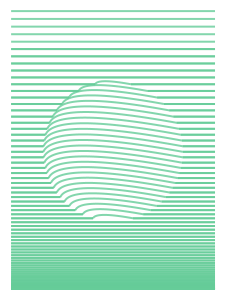

In [3]:
db = gp.Shape(drawbox)

rad = 75
center = db.p.centroid
circle = center.buffer(rad)

y_spacing = 0.01
y_spacing_delta = 0.12
y_start = db.bottom
y_end = db.top
y = y_start
ys = []
while y < y_end:
    y += y_spacing
    y_spacing += y_spacing_delta
    ys.append(y)
    
x_start = db.left
x_end = db.right
lss = [LineString(((x_start, y), (x_end, y))) for y in ys]
    
mls = MultiLineString(lss)
outside_circle_lss = mls.difference(circle)
within_circle_lss = mls.intersection(circle)
blss = []
for ls in within_circle_lss:
    bls = gp.LineString_to_jittered_bezier(ls, ybias=0.17, xbias=-0.43)
    blss.append(bls)
    
merged = MultiLineString(list(outside_circle_lss) + blss + list(outside_circle_lss)[:-5])
merged

# bez out, straight within

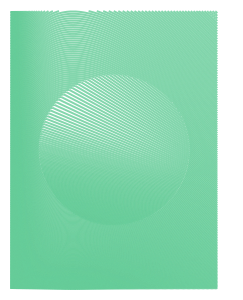

In [4]:
db = gp.Shape(drawbox)

rad = 80
center = db.p.centroid
circle = center.buffer(rad)

y_spacing = 0.01
y_spacing_delta = 0.01
y_start = db.bottom - 100
y_end = db.top
y = y_start
ys = []
while y < y_end:
    y += y_spacing
    y_spacing += y_spacing_delta
    ys.append(y)
    
x_start = db.left
x_end = db.right
lss = [LineString(((x_start, y), (x_end, y))) for y in ys]
    
blss = []
for ls in lss:
    bls = gp.LineString_to_jittered_bezier(ls, ybias=0.9, xbias=-0.4,n_eval_points=200)
    blss.append(bls)
    
blss = MultiLineString(blss)

outside_circle_lss = blss.difference(circle)
intersects_circle_lines = [ls for ls in blss if ls.intersects(circle)]
straight_inside_circle_lines = []
for ls in intersects_circle_lines:
    inside_circle = ls.intersection(circle)
    start = list(inside_circle.coords)[0]
    end = list(inside_circle.coords)[-1]
    straight_inside_circle_lines.append(LineString((start, end)))
    
straight_inside_circle_lines = MultiLineString(straight_inside_circle_lines)
merged = MultiLineString(list(outside_circle_lss)+ list(straight_inside_circle_lines) + list(outside_circle_lss)[-5:]).intersection(db.p)
merged

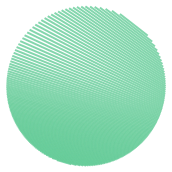

In [5]:
straight_inside_circle_lines

In [6]:
sk = vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('0.3mm')
for ii, ls in enumerate(merged):
    sk.stroke(ii+1)
    sk.geometry(ls)
sk.display(color_mode='layer')

<?xml version="1.0" encoding="utf-8" ?>
 
 
 
 
 image/svg+xml 
 
 2022-01-07T00:14:48.903928 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <polyline points="306.8009,113.3858 308.9531,114.0001 312.6846,114.98 316.4495,115.8846 320.2479,116.7138 324.0799,117.4677 327.9453,118.1461 331.8443,118.7492 335.7767,119.2768 339.7427,119.7291 343.7422,120.106 347.7751,120.4076 351.8416,120.6337 355.9416,120.7845 360.075,120.8599 364.242,120.8599 368.4425,120.7845 372.6765,120.6337 376.944,120.4076 381.2449,120.106 385.5794,119.7291 389.9474,119.2768 394.3489,118.7492 398.7839,118.1461 403.2524,117.4677 407.7545,116.7138 412.29,115.8846 416.859,114.98 421.4615,114.0001 424.1598,113.3858"/>
 
 
 <polyline points="303.5002,113.3858 305.2552,113.9274 308.9531,114.9827 312.6846,115.9627 316.4495,116.8673 320.2479,117.6965 324.0799,118.4503 327.9453,119.1288 331.8443,119.7318 335.7767,120.2595 339.7427,120.7118 343.7422,121.0887 347.7751,121.3903 351.8416,121.6164 355.9416,121.7672 360.075,121.8425 364.242,121.8425 368.4425,121.7672 372.6765,121.6164 376.944,121.3903 381.2449,121.0887 385.5794,120.7118 389.9474,120.2595 394.3489,119.7318 398.7839,119.1288 403.2524,118.4503 407.7545,117.6965 412.29,116.8673 416.859,115.9627 421.4615,114.9827 426.0975,113.9274 428.334,113.3858"/>
 
 
 <polyline points="300.2924,113.3858 301.5908,113.8171 305.2552,114.9479 308.9531,116.0032 312.6846,116.9832 316.4495,117.8878 320.2479,118.717 324.0799,119.4708 327.9453,120.1492 331.8443,120.7523 335.7767,121.28 339.7427,121.7323 343.7422,122.1092 347.7751,122.4107 351.8416,122.6369 355.9416,122.7876 360.075,122.863 364.242,122.863 368.4425,122.7876 372.6765,122.6369 376.944,122.4107 381.2449,122.1092 385.5794,121.7323 389.9474,121.28 394.3489,120.7523 398.7839,120.1492 403.2524,119.4708 407.7545,118.717 412.29,117.8878 416.859,116.9832 421.4615,116.0032 426.0975,114.9479 430.7671,113.8171 432.4488,113.3858"/>
 
 
 <polyline points="297.1642,113.3858 297.9599,113.6693 301.5908,114.8754 305.2552,116.0061 308.9531,117.0615 312.6846,118.0415 316.4495,118.946 320.2479,119.7752 324.0799,120.5291 327.9453,121.2075 331.8443,121.8106 335.7767,122.3383 339.7427,122.7905 343.7422,123.1675 347.7751,123.469 351.8416,123.6951 355.9416,123.8459 360.075,123.9213 364.242,123.9213 368.4425,123.8459 372.6765,123.6951 376.944,123.469 381.2449,123.1675 385.5794,122.7905 389.9474,122.3383 394.3489,121.8106 398.7839,121.2075 403.2524,120.5291 407.7545,119.7752 412.29,118.946 416.859,118.0415 421.4615,117.0615 426.0975,116.0061 430.7671,114.8754 435.4701,113.6693 436.5177,113.3858"/>
 
 
 <polyline points="294.105,113.3858 294.3624,113.4838 297.9599,114.7653 301.5908,115.9714 305.2552,117.1022 308.9531,118.1575 312.6846,119.1375 316.4495,120.0421 320.2479,120.8713 324.0799,121.6251 327.9453,122.3036 331.8443,122.9066 335.7767,123.4343 339.7427,123.8866 343.7422,124.2635 347.7751,124.5651 351.8416,124.7912 355.9416,124.942 360.075,125.0173 364.242,125.0173 368.4425,124.942 372.6765,124.7912 376.944,124.5651 381.2449,124.2635 385.5794,123.8866 389.9474,123.4343 394.3489,122.9066 398.7839,122.3036 403.2524,121.6251 407.7545,120.8713 412.29,120.0421 416.859,119.1375 421.4615,118.1575 426.0975,117.1022 430.7671,115.9714 435.4701,114.7653 440.2066,113.4838 440.5511,113.3858"/>
 
 
 <polyline points="291.1269,113.3858 294.3624,114.6177 297.9599,115.8992 301.5908,117.1053 305.2552,118.236 308.9531,119.2914 312.6846,120.2714 316.4495,121.176 320.2479,122.0052 324.0799,122.759 327.9453,123.4374 331.8443,124.0405 335.7767,124.5682 339.7427,125.0205 343.7422,125.3974 347.7751,125.6989 351.8416,125.9251 355.9416,126.0758 360.075,126.1512 364.242,126.1512 368.4425,126.0758 372.6765,125.9251 376.944,125.6989 381.2449,125.3974 385.5794,125.0205 389.9474,124.5682 394.3489,124.0405 398.7839,123.4374 403.2524,122.759 407.7545,122.0052 412.29,121.176 416.859,120.2714 421.4615,119.2914 426.0975,118.236 430.7671,117.1053 435.4701,115.8992 440.2066,114.6177 444.5371,113.3858"/>
 
 
 <pol

In [14]:
from pathlib import Path

In [15]:
plot_id = fn.new_plot_id()

saved 20220107-001459_580800-08f81-68849f to s3://algorithmic-ink/current_plot_id


In [16]:
savedir='/home/naka/art/plotter_svgs'

In [17]:
savepath = Path(savedir).joinpath(f'{plot_id}.svg').as_posix()
sk.save(savepath)

In [18]:
from genpen.axicam import AxiCam

In [27]:
ac = AxiCam()

In [28]:
ac.init_cam()

In [23]:
ac.cam.video_preview()

hit q to quit


In [24]:
ac.ad.options.speed_pendown = 30
ac.ad.options.speed_penup = 95
ac.ad.options.pen_delay_up = 5
ac.ad.update()

In [25]:
ac.plot_layers(wait_times=0.6)

100%|██████████| 532/532 [50:07<00:00,  5.65s/it]


In [29]:
ac.cam.save_image()